# AR1 Processes


<a id='index-0'></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
a, b, c = 0.9, 0.1, 0.5

mu, v = -3.0, 0.6  # initial conditions mu_0, v_0

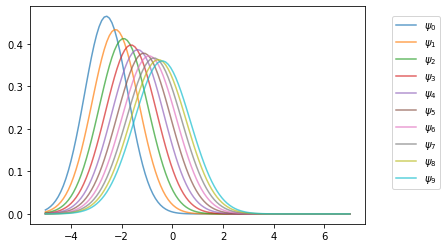

In [3]:
from scipy.stats import norm

sim_length = 10
grid = np.linspace(-5, 7, 120)

fig, ax = plt.subplots()

for t in range(sim_length):
    mu = a * mu + b
    v = a**2 * v + c**2
    ax.plot(grid, norm.pdf(grid, loc=mu, scale=np.sqrt(v)),
            label=f"$\psi_{t}$",
            alpha=0.7)

ax.legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=1)

plt.show()

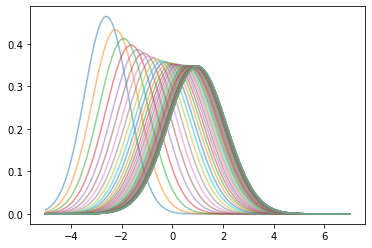

In [4]:
def plot_density_seq(ax, mu_0=-3.0, v_0=0.6, sim_length=60):
    mu, v = mu_0, v_0
    for t in range(sim_length):
        mu = a * mu + b
        v = a**2 * v + c**2
        ax.plot(grid,
                norm.pdf(grid, loc=mu, scale=np.sqrt(v)),
                alpha=0.5)

fig, ax = plt.subplots()
plot_density_seq(ax)
plt.show()

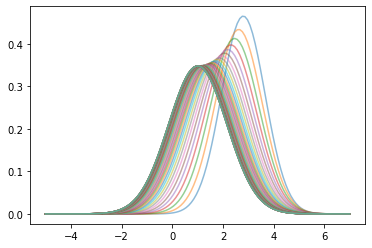

In [5]:
fig, ax = plt.subplots()
plot_density_seq(ax, mu_0=3.0)
plt.show()

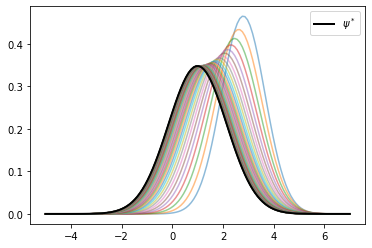

In [6]:
fig, ax = plt.subplots()
plot_density_seq(ax, mu_0=3.0)

mu_star = b / (1 - a)
std_star = np.sqrt(c**2 / (1 - a**2))  # square root of v_star
psi_star = norm.pdf(grid, loc=mu_star, scale=std_star)
ax.plot(grid, psi_star, 'k-', lw=2, label="$\psi^*$")
ax.legend()

plt.show()

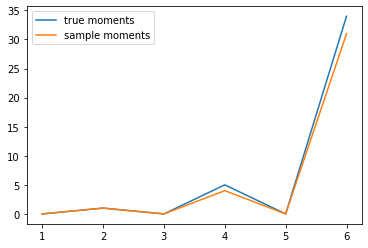

In [7]:
from numba import njit
from scipy.special import factorial2

@njit
def sample_moments_ar1(k, m=100_000, mu_0=0.0, sigma_0=1.0, seed=1234):
    np.random.seed(seed)
    sample_sum = 0.0
    x = mu_0 + sigma_0 * np.random.randn()
    for t in range(m):
        sample_sum += (x - mu_star)**k
        x = a * x + b + c * np.random.randn()
    return sample_sum / m

def true_moments_ar1(k):
    if k % 2 == 0:
        return std_star**k * factorial2(k - 1)
    else:
        return 0

k_vals = np.arange(6) + 1
sample_moments = np.empty_like(k_vals)
true_moments = np.empty_like(k_vals)

for k_idx, k in enumerate(k_vals):
    sample_moments[k_idx] = sample_moments_ar1(k)
    true_moments[k_idx] = true_moments_ar1(k)

fig, ax = plt.subplots()
ax.plot(k_vals, true_moments, label="true moments")
ax.plot(k_vals, sample_moments, label="sample moments")
ax.legend()

plt.show()

In [8]:
K = norm.pdf

class KDE:

    def __init__(self, x_data, h=None):

        if h is None:
            c = x_data.std()
            n = len(x_data)
            h = 1.06 * c * n**(-1/5)
        self.h = h
        self.x_data = x_data

    def f(self, x):
        if np.isscalar(x):
            return K((x - self.x_data) / self.h).mean() * (1/self.h)
        else:
            y = np.empty_like(x)
            for i, x_val in enumerate(x):
                y[i] = K((x_val - self.x_data) / self.h).mean() * (1/self.h)
            return y

In [9]:
def plot_kde(ϕ, x_min=-0.2, x_max=1.2):
    x_data = ϕ.rvs(n)
    kde = KDE(x_data)

    x_grid = np.linspace(-0.2, 1.2, 100)
    fig, ax = plt.subplots()
    ax.plot(x_grid, kde.f(x_grid), label="estimate")
    ax.plot(x_grid, ϕ.pdf(x_grid), label="true density")
    ax.legend()
    plt.show()

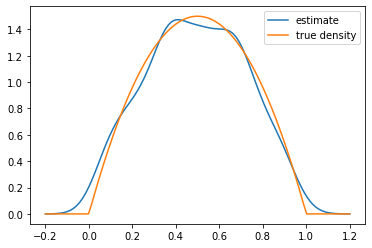

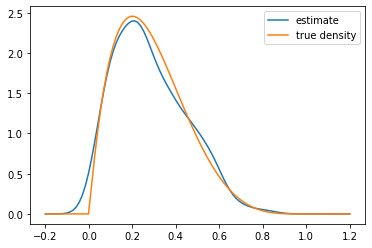

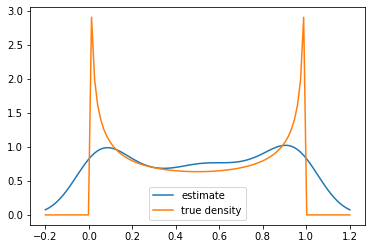

In [10]:
from scipy.stats import beta

n = 500
parameter_pairs= (2, 2), (2, 5), (0.5, 0.5)
for α, β in parameter_pairs:
    plot_kde(beta(α, β))

In [11]:
a = 0.9
b = 0.0
c = 0.1
μ = -3
s = 0.2

In [12]:
μ_next = a * μ + b
s_next = np.sqrt(a**2 * s**2 + c**2)

In [13]:
ψ = lambda x: K((x - μ) / s)
ψ_next = lambda x: K((x - μ_next) / s_next)

In [14]:
ψ = norm(μ, s)
ψ_next = norm(μ_next, s_next)

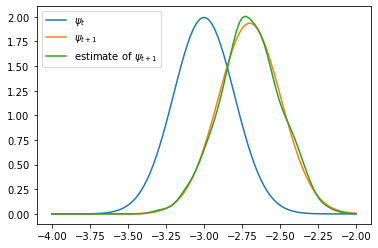

In [15]:
n = 2000
x_draws = ψ.rvs(n)
x_draws_next = a * x_draws + b + c * np.random.randn(n)
kde = KDE(x_draws_next)

x_grid = np.linspace(μ - 1, μ + 1, 100)
fig, ax = plt.subplots()

ax.plot(x_grid, ψ.pdf(x_grid), label="$\psi_t$")
ax.plot(x_grid, ψ_next.pdf(x_grid), label="$\psi_{t+1}$")
ax.plot(x_grid, kde.f(x_grid), label="estimate of $\psi_{t+1}$")

ax.legend()
plt.show()